In [1]:
import collections.abc
collections.Iterable = collections.abc.Iterable #Issue in evcouplings I think - change in structure
import os
import argparse
from datetime import datetime
import subprocess
import multiprocessing as mp
import logging
from tqdm import tqdm
from typing import Callable, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy
import itertools
from tabulate import tabulate
from scipy.linalg import block_diag

import torch
import torch.nn as nn
from torch.distributions import Transform, transform_to
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.inspect import get_model_relations, generate_graph_specification, render_graph

from evcouplings.couplings import CouplingsModel
from alignmenttools.MultipleSequenceAlignment import MultipleSequenceAlignment as MSA
from alignmenttools.MultipleSequenceAlignment import readAlignment

# Data loading

In [2]:
def read_fasta(name, form = '.fa'):
    '''
    Read alignment file into MSA object
    '''
    return readAlignment(name + '.' + form)

alphabet = 'ACDEFGHIKLMNPQRSTVWY'
the_rest = 'BJOUXZ'
gap = '-'

onehot_dicts = [{}]*2

#Making dictionaries for conversion from letters to one-hot dictionaries
#if treating gaps as characters
onehot_dicts[0] = {letter: ([0] * (len(alphabet)+1)) for letter in the_rest}
for i, letter in enumerate(gap + alphabet): #check to see where gaps come in the hi, Jij matrix - I believe it's at the start
    onehot_dicts[0][letter] = [0] * i + [1] + [0] * (len(alphabet) - i)

#if ignoring gaps
onehot_dicts[1] = {letter: ([0] * len(alphabet)) for letter in the_rest + gap}
for i, letter in enumerate(alphabet):
    onehot_dicts[1][letter] = [0] * i + [1] + [0] * (len(alphabet) - i - 1)

def onehot_seqs(msa_obj, gap_ignore):
    '''
    Convert letter sequences to onehot
    '''
    onehot_dict = onehot_dicts[gap_ignore]
    full_ans = [[] for seq in msa_obj.matrix]
    for i, seq in enumerate(msa_obj.matrix):
        for letter in seq:
            full_ans[i] += onehot_dict[letter]
            
    return full_ans

def data_init(name, device):
    '''
    Get Pyro-handleable data
    '''
    msa = read_fasta(*name.split('.')) #name is an input variable
    gap_ignore = 1 #set variable options later? same for alphabet_size?
    alphabet_size = 21 - gap_ignore
#     device = torch.device('cuda') #also needs to be an option
    
    pll_onehot = torch.tensor(np.array(onehot_seqs(msa, gap_ignore)).T, dtype = torch.float32, device = device)
    pll_onehot_3d = pll_onehot.reshape(msa.L, alphabet_size, msa.N)
    
    return msa.L, msa.N, alphabet_size, pll_onehot

In [3]:
def hi_to_onehot(hi, device):
    '''
    Convert 2D (L x alphabet_size) h_i (fields) matrix to 2D (L*alphabet_size x 1) using onehot
    '''
    return torch.tensor(np.expand_dims(hi, -1), device = device, dtype = torch.float32)
#    return torch.tensor(hi.reshape(-1, 1), device = device, dtype = torch.float32)

def Jij_to_onehot(Jij, device):
    '''
    Convert 4D (L x L x alphabet_size x alphabet_size) J_ij (pairwise terms) matrix to 2D (L*alphabet_size x L*alphabet_size) using onehot
    '''
    return torch.tensor(Jij.swapaxes(2, 1).reshape(Jij.shape[0] * Jij.shape[-1], Jij.shape[0] * Jij.shape[-1]), device = device, dtype = torch.float32)

In [4]:
file_name = 'sh3_pdz/sh3_trimmed.fa'
device = torch.device('cpu')
L, N, alphabet_size, pll_onehot = data_init(file_name, device)

In [5]:
model = CouplingsModel('sh3_pdz/sh3.params')
hi = hi_to_onehot(model.h_i, device)
Jij = Jij_to_onehot(model.J_ij, device)

### Normal prior, regularization (-le = 16)

# Potts Model in Pyro

In [6]:
def get_block_I(L, alphabet_size, device):
    block = np.ones((alphabet_size, alphabet_size))
    return torch.tensor(block_diag(*([block] * L)), device = device, dtype = torch.float32)

In [7]:
class _Jij_Constraint(constraints.Constraint):
    #what was the transformation thing again?
    def __init__(self, L, alphabet_size, device):
        self.L = L
        self.alphabet_size = alphabet_size
        self.device = device
        self.block_I = get_block_I(L, alphabet_size, device)
    
    def check(self, Jij):
        return (not torch.any(torch.mul(self.block_I, Jij))) and (torch.all(Jij == Jij.T))
        #Check 0s along diagonal squares (torch.all(torch.mul(I_ish, Jij) == 0)) | symmetric (Jij == Jij.T)
        pass

class Jij_Transform(Transform):
    bijective = False
    def __init__(self, L, alphabet_size, device, cache_size=0):
        self._cache_size = cache_size
        self.L = L
        self.alphabet_size = alphabet_size
        self.block_I_minus = 1 - get_block_I(L, alphabet_size, device)
        self.device = device
    
    domain = constraints.real_vector
    _inv = None
    
    @constraints.dependent_property
    def codomain(self):
        return _Jij_Constraint(self.L, self.alphabet_size, self.device)
    
    def _call(self, x):
        x = torch.mul(x, self.block_I_minus)
        return (x + x.T)/2
    
    def _inverse(self, x):
        return x
    
@transform_to.register(_Jij_Constraint)
def my_factory(constraint):
    assert isinstance(constraint, _Jij_Constraint)
    return Jij_Transform(constraint.L, constraint.alphabet_size, constraint.device)

In [8]:
# class PLL(dist.Distribution):
#     arg_constraints = {'Jij': _Jij_Constraint}
    
#     def __init__(self, hi, Jij):
#         self.L = hi.shape[0]
#         self.alphabet_size = hi.shape[1]
#         self.hi = hi #L x alphabet_size x 1
#         self.Jij = Jij.reshape(self.L, self.alphabet_size, self.L*self.alphabet_size) #L*alphabet_size x L*alphabet_size
# #         print(Jij)
    
#     def sample(self, *args, **kwargs):
#         pass
        
#     def log_prob(self, pll_onehot):
#         #regularization?
#         #wish I could just pass both in but here we are
#         UI = self.hi + torch.matmul(self.Jij, pll_onehot)
#         ll_energies = nn.functional.log_softmax(UI, dim = 1)
#         return torch.sum(torch.mul(ll_energies, pll_onehot.reshape(self.L, self.alphabet_size, -1)), dim = (0, 1))

In [9]:
class PLL(dist.Distribution):
#     arg_constraints = {'Jij': _Jij_Constraint}
    
    def __init__(self, hi, Jij):
        self.L = hi.shape[-3]
        self.alphabet_size = hi.shape[-2]
        self.hi = hi.reshape(-1, self.L, self.alphabet_size, 1) #L x alphabet_size x 1
        self.Jij = Jij.reshape(-1, self.L, self.alphabet_size, self.L*self.alphabet_size)#L*alphabet_size x L*alphabet_size
#         print(self.hi.shape, self.Jij.|shape)
    
    def sample(self, *args, **kwargs):
        pass
        
    def log_prob(self, pll_onehot):
        #regularization?
        #wish I could just pass both in but here we are
#         print(self.Jij.shape)
#         print(pll_onehot.shape)
        UI = self.hi + torch.matmul(self.Jij, pll_onehot)
        ll_energies = nn.functional.log_softmax(UI, dim = 1)
#         print(torch.sum(torch.mul(ll_energies, pll_onehot.reshape(self.L, self.alphabet_size, -1)), dim = (1, 2)).shape)
        return torch.sum(torch.mul(ll_energies, pll_onehot.reshape(self.L, self.alphabet_size, -1)), dim = (-3, -2))

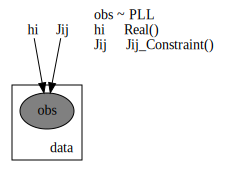

In [10]:
pyro.clear_param_store()
def model(L, alphabet_size, device, msa_onehot = None):
    '''
    Okay so this is supposed to represent the true model but we don't have the ability to sample from that...
    so I guess we're saying the pseudolikelihood is the true?
    Inputs:
    L (int): sequence length
    alphabet_size (int): number of amino acids available
    boltz_approx: function that generates a Boltzmann distribution approximation
    '''
    hi = pyro.param("hi", lambda: torch.randn(L, alphabet_size, 1))
    Jij = pyro.param("Jij", lambda: torch.randn(L*alphabet_size, L*alphabet_size), constraint = _Jij_Constraint(L, alphabet_size, device))
    
    pll_dist = PLL(hi, Jij)
    with pyro.plate("data", msa_onehot.shape[-1]):
        return pyro.sample("obs", pll_dist, obs = msa_onehot)

pyro.render_model(model, model_args=(L, alphabet_size, device, pll_onehot), render_distributions = True, render_params = True)

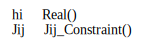

In [11]:
pyro.clear_param_store()
def custom_guide(L, alphabet_size, device, msa_onehot = None):
    hi = pyro.param("hi", lambda: torch.randn(L, alphabet_size, 1, device = device))
    def sym_rand():
        x = torch.randn(L*alphabet_size, L*alphabet_size, device = device)
        x = x - torch.mul(x, get_block_I(L, alphabet_size, device))
        return (x+x.T)/2
    Jij = pyro.param("Jij", sym_rand, constraint = _Jij_Constraint(L, alphabet_size, device)) #I need constraints... actually how do I do constraints    return {'hi': hi, "Jij": Jij}
#     print(Jij)
    
pyro.render_model(custom_guide, model_args=(L, alphabet_size, device, pll_onehot), render_distributions = True, render_params = True)

# Potts Mixture Model

Provenance:
frozenset({'locs'})
Tensor:
tensor([10.1826, -3.7149]) torch.Size([5])
torch.Size([5, 41, 20, 1])


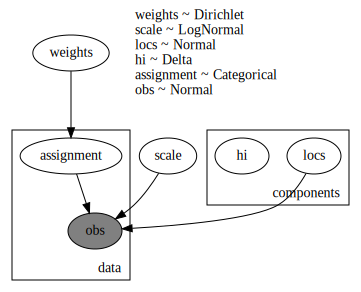

In [12]:
K = 2  # Fixed number of components.
pyro.clear_param_store()
@pyro.infer.config_enumerate
def model(data=None):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
#         hi_locs = pyro.param("hi_locs", lambda: torch.zeros((L, alphabet_size, 1), device = device))
#         hi_scales = pyro.param("hi_scales", lambda: torch.full((L, alphabet_size, 1), 0.001, device = device), constraint = constraints.positive)
        hi = pyro.sample("hi", dist.Delta(torch.randn(L, alphabet_size, 1), event_dim = 3))

    with pyro.plate('data', data.shape[-1]):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        print(locs, locs[assignment].shape)
        print(hi[assignment].shape)
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)
        
d = torch.tensor([0., 1., 10., 11., 12.])

pyro.render_model(model, model_args=(d,), render_distributions = True, render_params = True)

In [13]:
pyro.clear_param_store()
@pyro.infer.config_enumerate
def mixture_model(L, alphabet_size, device, K, msa_onehot = None):
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#     print(weights)
    with pyro.plate('components', K):
        his = pyro.sample("hi", dist.Delta(torch.randn(L, alphabet_size, 1, device = device), event_dim = 3))
#         print('his plate shape', his.shape)
        Jijs = pyro.sample("Jij", dist.Delta(torch.randn(L*alphabet_size, L*alphabet_size, device = device), event_dim = 2))
    
#         print('Jijs plate shape', Jijs.shape)
    plls = np.array([PLL(hi, Jij) for hi, Jij in zip(his, Jijs)])

    for i in pyro.plate("data", msa_onehot.shape[-1]):
        assignment = pyro.sample('assignment_{}'.format(i), dist.Categorical(weights))
#         #looks like the assignment indexing is overflowing memory... ass
#     for i in pyro.plate("data_loop", msa_onehot.shape[-1]):
#         print(Jijs.shape)
#         print(his.shape)
        
#         print(his[assignment].shape, Jijs[assignment].shape)
        pyro.sample("obs_{}".format(i) , plls[assignment], obs = msa_onehot[:,i:i+1])

pyro.render_model(mixture_model, model_args=(L, alphabet_size, device, 2, pll_onehot), render_distributions = True, render_params = True)

CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tsvg']' returned non-zero exit status 3221225725. [stderr: '']

In [28]:
inds = torch.tensor([3,2])
thingy = np.array(['hi', 'hello', 'sup', 'dog', 'it'])
thingy[np.array([2, 1, 4])]
thingy[inds]

array(['dog', 'sup'], dtype='<U5')

# Bayesian Potts Model with the pretty arrow

In [14]:
def Jij_unpack(L, alphabet_size, Jij_packed):
    ans = torch.zeros(L, L, alphabet_size, alphabet_size, device = Jij_packed.device)
    inds = torch.triu_indices(L, L, offset = 1)
    ans[inds[0], inds[1]] = Jij_packed
    ans1 = ans + ans.swapaxes(0, 1).swapaxes(2, 3)
    return ans1.swapaxes(1, 2).reshape(L, alphabet_size, L*alphabet_size)

def Jij_pack(L, alphabet_size, Jij_packed):
    Jij_thick = Jij_packed.reshape(L, alphabet_size, L, alphabet_size).swapaxes(1, 2)
    inds = torch.triu_indices(L, L, offset = 1)
    return Jij_thick[inds[0], inds[1]]

In [15]:
class PLL(dist.Distribution):
    
    def __init__(self, hi, Jij):
        self.L = hi.shape[0]
        self.alphabet_size = hi.shape[1]
        self.hi = hi #L x alphabet_size x 1
        self.Jij = Jij_unpack(self.L, self.alphabet_size, Jij) #L x alphabet_size x L*alphabet_size
    
    def sample(self, *args, **kwargs):
        pass
        
    def log_prob(self, pll_onehot):
        UI = self.hi + torch.matmul(self.Jij, pll_onehot)
        ll_energies = nn.functional.log_softmax(UI, dim = 1)
        return torch.sum(torch.mul(ll_energies, pll_onehot.reshape(self.L, self.alphabet_size, -1)), dim = (0, 1))

In [16]:
def render_model(
    model: Callable,
    model_args: Optional[tuple] = None,
    model_kwargs: Optional[dict] = None,
    filename: Optional[str] = None,
    render_distributions: bool = False,
    render_params: bool = False,
) -> "graphviz.Digraph":
    """
    Renders a model using `graphviz <https://graphviz.org>`_ . BUT WITH MY JIJ DEPENDENCY
    If ``filename`` is provided, this saves an image; otherwise this draws the
    graph. For example usage see the
    `model rendering tutorial <https://pyro.ai/examples/model_rendering.html>`_ .
    :param model: Model to render.
    :param model_args: Positional arguments to pass to the model.
    :param model_kwargs: Keyword arguments to pass to the model.
    :param str filename: File to save rendered model in.
    :param bool render_distributions: Whether to include RV distribution
        annotations (and param constraints) in the plot.
    :param bool render_params: Whether to show params in the plot.
    :returns: A model graph.
    :rtype: graphviz.Digraph
    """
    assert model_args is None or isinstance(
        model_args, tuple
    ), "model_args must be None or tuple"
    assert model_kwargs is None or isinstance(
        model_kwargs, dict
    ), "model_kwargs must be None or dict"
    relations = get_model_relations(model, model_args, model_kwargs)
    if 'Jij' in relations['sample_sample'] and 'obs' in relations['sample_sample']:
        if 'Jij' not in relations['sample_sample']['obs']:
            relations['sample_sample']['obs'].append('Jij')
    
    graph_spec = generate_graph_specification(relations, render_params=render_params)
    graph = render_graph(graph_spec, render_distributions=render_distributions)

    if filename is not None:
        filename = Path(filename)
        suffix = filename.suffix[1:]  # remove leading period from suffix
        graph.render(filename.stem, view=False, cleanup=True, format=suffix)

    return graph

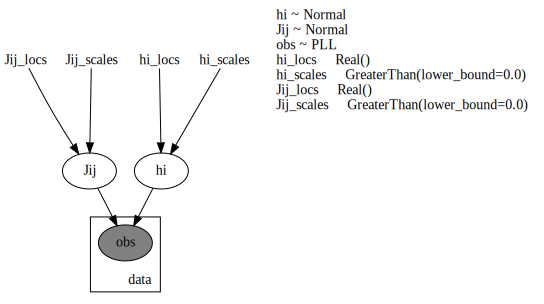

In [17]:
pyro.clear_param_store()

def model(L, alphabet_size, device, msa_onehot = None):
    '''
    Okay so this is supposed to represent the true model but we don't have the ability to sample from that...
    so I guess we're saying the pseudolikelihood is the true?
    Inputs:
    L (int): sequence length
    alphabet_size (int): number of amino acids available
    boltz_approx: function that generates a Boltzmann distribution approximation
    '''
    hi_locs = pyro.param("hi_locs", lambda: torch.zeros((L, alphabet_size, 1), device = device))
    hi_scales = pyro.param("hi_scales", lambda: torch.full((L, alphabet_size, 1), 0.001, device = device), constraint = constraints.positive)
    hi = pyro.sample("hi", dist.Normal(hi_locs, hi_scales).to_event(3))
    
    Jij_locs = pyro.param("Jij_locs", lambda: torch.zeros((int(L*(L-1)/2), alphabet_size, alphabet_size), device = device))
    Jij_scales = pyro.param("Jij_scales", lambda: torch.full((int(L*(L-1)/2), alphabet_size, alphabet_size), 0.01, device = device), constraint = constraints.positive)
    Jij = pyro.sample("Jij", dist.Normal(Jij_locs, Jij_scales).to_event(3))
    
    pll_dist = PLL(hi, Jij)
    with pyro.plate("data", msa_onehot.shape[-1]):
        return pyro.sample("obs", pll_dist, obs = msa_onehot)

render_model(model, model_args=(L, alphabet_size, device, pll_onehot), render_distributions = True, render_params = True)

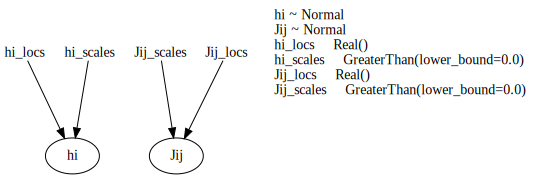

In [10]:
pyro.clear_param_store()

def custom_guide(L, alphabet_size, device, msa_onehot = None):
    hi_locs = pyro.param("hi_locs", lambda: torch.zeros((L, alphabet_size, 1), device = device))
    hi_scales = pyro.param("hi_scales", lambda: torch.full((L, alphabet_size, 1), 0.001, device = device), constraint = constraints.positive)
    hi = pyro.sample("hi", dist.Normal(hi_locs, hi_scales).to_event(3))
    
    Jij_locs = pyro.param("Jij_locs", lambda: torch.zeros((int(L*(L-1)/2), alphabet_size, alphabet_size), device = device))
    Jij_scales = pyro.param("Jij_scales", lambda: torch.full((int(L*(L-1)/2), alphabet_size, alphabet_size), 0.01, device = device), constraint = constraints.positive)
    Jij = pyro.sample("Jij", dist.Normal(Jij_locs, Jij_scales).to_event(3))
    return {"hi": hi, "Jij": Jij}
    
pyro.render_model(custom_guide, model_args=(L, alphabet_size, device, pll_onehot), render_distributions = True, render_params = True)

## Mix?

In [11]:
def Jij_unpack(L, alphabet_size, Jij_packed):
    K = Jij_packed.shape[0]
    ans = torch.zeros(K, L, L, alphabet_size, alphabet_size, device = Jij_packed.device)
    inds = torch.triu_indices(L, L, offset = 1) #I want one of these for each of the K
    for i in range(K):
        ans[i, inds[0], inds[1]] = Jij_packed[i]
    ans1 = ans + ans.swapaxes(-4, -3).swapaxes(-2, -1)
    return ans1.swapaxes(-3, -2).reshape(K, L, alphabet_size, L*alphabet_size)

def Jij_pack(L, alphabet_size, Jij_packed):
    Jij_thick = Jij_packed.reshape(L, alphabet_size, L, alphabet_size).swapaxes(1, 2)
    inds = torch.triu_indices(L, L, offset = 1)
    return Jij_thick[inds[0], inds[1]]

In [13]:
class PLLs(dist.Distribution):
    
    def __init__(self, hi, Jij):
        self.L = hi.shape[-3]
        self.alphabet_size = hi.shape[-2]
        self.hi = hi #L x alphabet_size x 1
        self.Jij = Jij_unpack(self.L, self.alphabet_size, Jij) #L x alphabet_size x L*alphabet_size
        self.K = hi.shape[0]
    
    def sample(self, *args, **kwargs):
        pass
        
    def log_prob(self, assignment, pll_onehot):
        UI = self.hi + torch.matmul(self.Jij, pll_onehot)
        ll_energies = nn.functional.log_softmax(UI, dim = -2)
        return torch.sum(torch.mul(ll_energies, pll_onehot.reshape(self.L, self.alphabet_size, -1)), dim = (-3, -2))

In [22]:
pyro.clear_param_store()
@pyro.infer.config_enumerate
def mixture_model(L, alphabet_size, device, K, msa_onehot = None):
    
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#     print(weights)
    with pyro.plate('components', K):
        hi_locs = pyro.param("hi_locs", lambda: torch.zeros((L, alphabet_size, 1), device = device))
        hi_scales = pyro.param("hi_scales", lambda: torch.full((L, alphabet_size, 1), 0.001, device = device), constraint = constraints.positive)
        hi = pyro.sample("hi", dist.Normal(hi_locs, hi_scales).to_event(3))

        Jij_locs = pyro.param("Jij_locs", lambda: torch.zeros((int(L*(L-1)/2), alphabet_size, alphabet_size), device = device))
        Jij_scales = pyro.param("Jij_scales", lambda: torch.full((int(L*(L-1)/2), alphabet_size, alphabet_size), 0.01, device = device), constraint = constraints.positive)
        Jij = pyro.sample("Jij", dist.Normal(Jij_locs, Jij_scales).to_event(3))
    
    pll_dists = PLLs(hi, Jij)
    
    with pyro.plate("data", msa_onehot.shape[-1]):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
#         #looks like the assignment indexing is overflowing memory... ass
#     for i in pyro.plate("data_loop", msa_onehot.shape[-1]):
#         print(Jijs.shape)
#         print(his.shape)
        
#         print(his[assignment].shape, Jijs[assignment].shape)
        pyro.sample("obs" , PLL(hi[assignment], Jij[assignment]), obs = msa_onehot)

pyro.render_model(mixture_model, model_args=(L, alphabet_size, device, 2, pll_onehot), render_distributions = True, render_params = True)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not type

# Run it

- Param vs. Bayesian
- Single vs. Mixture
- (Bayesian Mixture) batched/looped vs. mixture distribution

- Normal prior
- Make data; I think that's done
- ELBO regularization?
- Comparison: PLL, num true positives, couplings map

- Read about EVE, SVi

100%|██████████| 1000/1000 [00:21<00:00, 45.64it/s]

Wall time: 21.9 s


Text(0, 0.5, 'ELBO loss')

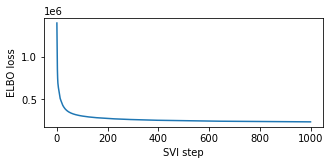

In [266]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

losses = []
for step in tqdm(range(1000)):  # Consider running for more steps.
#     print(svi)
    loss = svi.step(L, alphabet_size, device, pll_onehot)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [267]:
svi.__dict__

{'model': <function __main__.model(L, alphabet_size, device, msa_onehot=None)>,
 'guide': <function __main__.custom_guide(L, alphabet_size, device, msa_onehot=None)>,
 'optim': <pyro.optim.optim.PyroOptim at 0x224bef78e50>,
 'num_steps': 0,
 'num_samples': 0,
 'num_chains': 1,
 'log_weights': [],
 'exec_traces': [],
 'chain_ids': [],
 '_idx_by_chain': [[]],
 '_categorical': None,
 'loss': <bound method Trace_ELBO.loss of <pyro.infer.trace_elbo.Trace_ELBO object at 0x00000224BEF78EB0>>,
 'loss_and_grads': <bound method Trace_ELBO.loss_and_grads of <pyro.infer.trace_elbo.Trace_ELBO object at 0x00000224BEF78EB0>>}

In [268]:
[(obj, pyro.get_param_store()._params[obj].shape) for obj in pyro.get_param_store()._params]

[('hi_locs', torch.Size([41, 20, 1])),
 ('hi_scales', torch.Size([41, 20, 1])),
 ('Jij_locs', torch.Size([820, 20, 20])),
 ('Jij_scales', torch.Size([820, 20, 20]))]

In [306]:
def get_params(param_store):
    hi = dist.Normal(param_store['hi_locs'], param_store['hi_scales'])
    Jij = dist.Normal(param_store['Jij_locs'], param_store['Jij_scales'])
#     if len(Jij[0].shape) == 2:
#         Jij = (Jij_unpack(L, alphabet_size, device, Jij[0]), Jij_unpack(L, alphabet_size, device, Jij[1]))
    return hi, Jij
hi_inf, Jij_inf = get_params(pyro.get_param_store())

In [308]:
Jij_inf.sample().shape

torch.Size([820, 20, 20])

In [310]:
def pll(pll_onehot, hi, Jij):
    '''
    Calculate pseudolikelihood of each sequence in the MSA
    pll_onehot: alphabet_size*L x N
    pll_onehot_3d: L x alphabet_size x N
    pos_I: L x alphabet_size x alphabet_size*L
    hi: alphabet_size*L
    Jij: alphabet_size*L x alphabet_size*L
    '''
    UI = hi + torch.matmul(Jij, pll_onehot)
    ll_energies = nn.functional.log_softmax(UI, dim = 1)
    return torch.sum(torch.mul(ll_energies, pll_onehot.reshape(L, alphabet_size, -1)), dim = (0, 1))

In [311]:
plmc_plls = pll(pll_onehot, hi, Jij.reshape(L, alphabet_size, -1))


In [289]:
Jij_inf.sample().shape

torch.Size([820, 20, 20])

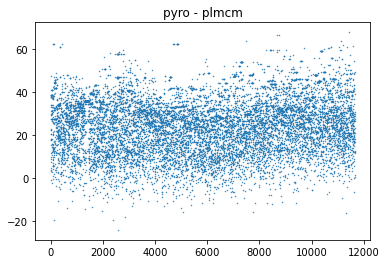

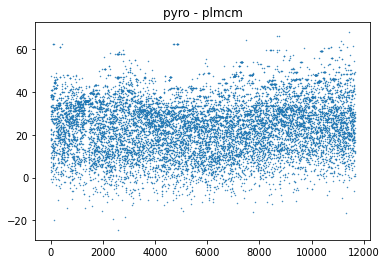

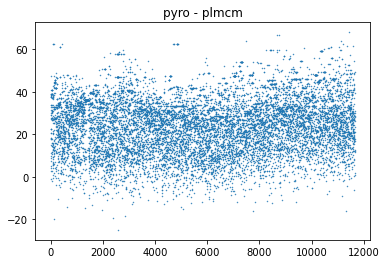

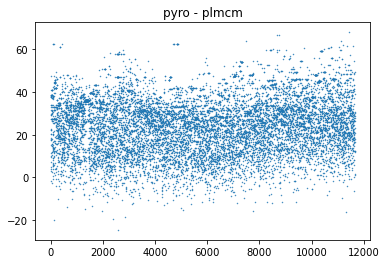

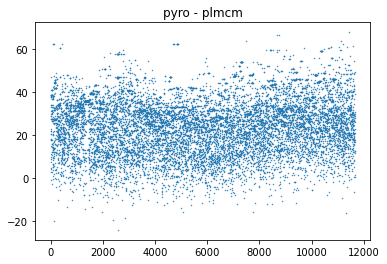

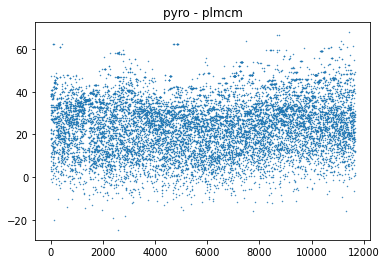

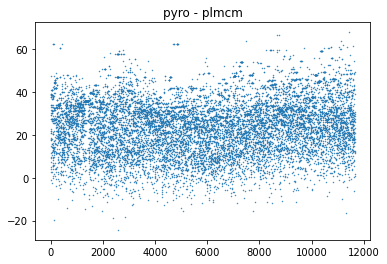

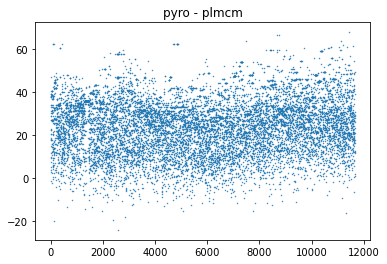

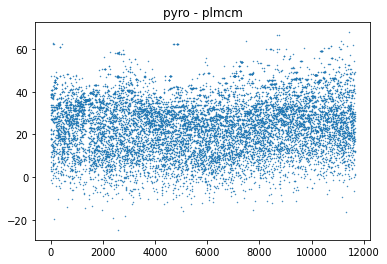

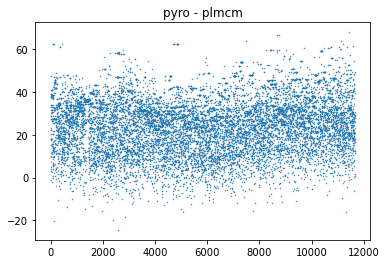

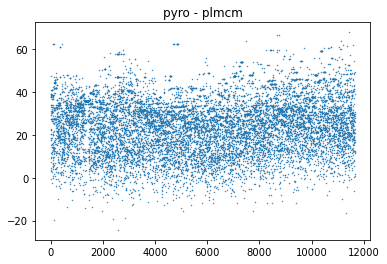

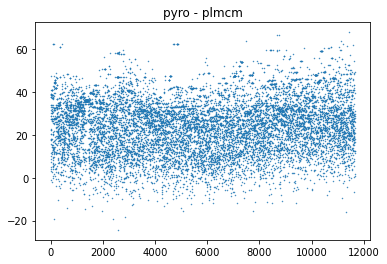

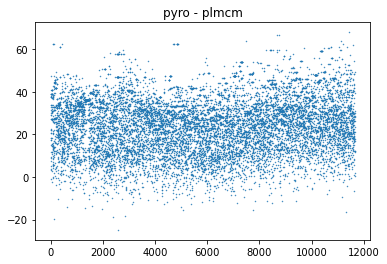

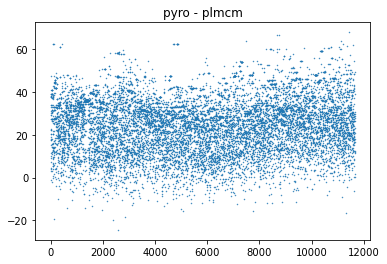

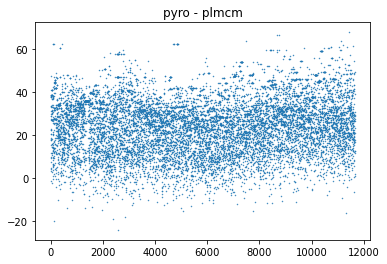

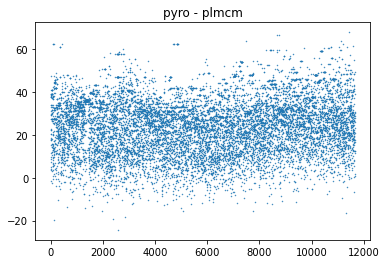

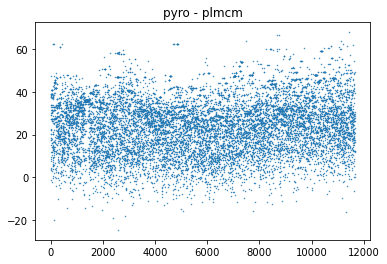

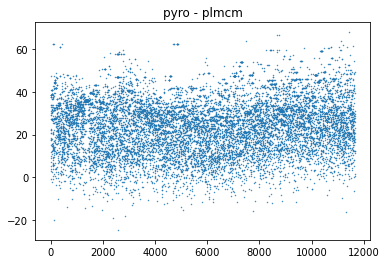

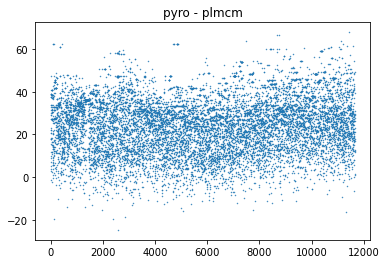

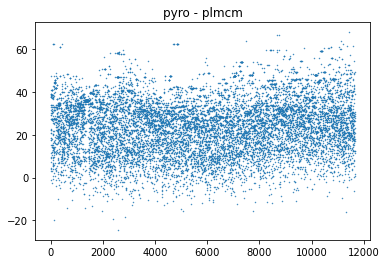

In [326]:
for i in range(20):
    pyro_plls = pll(pll_onehot, hi_inf.sample(), Jij_unpack(L, alphabet_size, device, Jij_inf.sample()))
    plt.scatter(range(len(plmc_plls.cpu())), pyro_plls.cpu().detach().numpy() - plmc_plls.cpu().detach().numpy(), s = 0.2)
    plt.title('pyro - plmcm')
    plt.show()

In [323]:
print("Pyro")
print('hi L2', float(torch.sqrt(torch.mean(hi_inf.loc**2))))
print('Jij L2', float(torch.sqrt(torch.mean(Jij_unpack(L, alphabet_size, device, Jij_inf.loc**2)))))
print((pyro_plls[:6]).cpu().detach().numpy())

Pyro
hi L2 0.43832969665527344
Jij L2 1.519415020942688
[-11.888972 -14.198833 -22.630665 -13.605193 -22.630665 -13.605193]


In [318]:
print("PLMC")
print('hi L2', float(torch.sqrt(torch.mean(hi**2))))
print('Jij L2', float(torch.sqrt(torch.mean(Jij**2))))
print((plmc_plls[:6]).cpu().detach().numpy())

PLMC
hi L2 1.8316826820373535
Jij L2 0.07457507401704788
[-59.25863  -36.896545 -40.286133 -35.61882  -40.286133 -35.61882 ]


# Error chasing - turns out you just do to_event like it said ugh

In [89]:
from itertools import zip_longest

In [152]:
def loss_and_grads(model, guide, *args, **kwargs):
    """
    :returns: returns an estimate of the ELBO
    :rtype: float
    Computes the ELBO as well as the surrogate ELBO that is used to form the gradient estimator.
    Performs backward on the latter. Num_particle many samples are used to form the estimators.
    """
    loss = 0.0
    # grab a trace from the generator
#     print([type(arg) for arg in args])
    for model_trace, guide_trace in _get_traces(model, guide, args, kwargs):
#             loss_particle, surrogate_loss_particle = self._differentiable_loss_particle(
#                 model_trace, guide_trace
#             )
#             loss += loss_particle / self.num_particles

#             # collect parameters to train from model and guide
#             trainable_params = any(
#                 site["type"] == "param"
#                 for trace in (model_trace, guide_trace)
#                 for site in trace.nodes.values()
#             )

#             if trainable_params and getattr(
#                 surrogate_loss_particle, "requires_grad", False
#             ):
#                 surrogate_loss_particle = surrogate_loss_particle / self.num_particles
#                 surrogate_loss_particle.backward(retain_graph=self.retain_graph)
#         warn_if_nan(loss, "loss")
#         return loss
        'hi'
    pass
    
def _get_traces(model, guide, args, kwargs):
    """
    Runs the guide and runs the model against the guide with
    the result packaged as a trace generator.
    """
    #max plate nesting is infinite
    if elbo.vectorize_particles:
        if elbo.max_plate_nesting == float("inf"):
            elbo._guess_max_plate_nesting(model, guide, args, kwargs)
        yield elbo._get_vectorized_trace(model, guide, args, kwargs)
    else:
        #1 particle
        for i in range(elbo.num_particles):
            yield _get_trace(model, guide, args, kwargs)
    
def _get_trace(model, guide, args, kwargs):
    """
    Returns a single trace from the guide, and the model that is run
    against it.
    """
    model_trace, guide_trace = get_importance_trace(
        "flat", elbo.max_plate_nesting, model, guide, args, kwargs
    )
    if is_validation_enabled():
        check_if_enumerated(guide_trace)
    return model_trace, guide_trace
    
    
def get_importance_trace(
    graph_type, max_plate_nesting, model, guide, args, kwargs, detach=False
):
    """
    Returns a single trace from the guide, which can optionally be detached,
    and the model that is run against it.
    """
    # Dispatch between callables vs GuideMessengers.
    unwrapped_guide = pyro.poutine.unwrap(guide)
    if isinstance(unwrapped_guide, pyro.poutine.messenger.Messenger):
        if detach:
            raise NotImplementedError("GuideMessenger does not support detach")
        guide(*args, **kwargs)
        model_trace, guide_trace = unwrapped_guide.get_traces()
    else:
        guide_trace = pyro.poutine.trace(guide, graph_type=graph_type).get_trace(
            *args, **kwargs
        )
        if detach:
            guide_trace.detach_()
        model_trace = pyro.poutine.trace(
            pyro.poutine.replay(model, trace=guide_trace), graph_type=graph_type
        ).get_trace(*args, **kwargs)

#     if True:
#         check_model_guide_match(model_trace, guide_trace, max_plate_nesting)

    guide_trace = pyro.poutine.util.prune_subsample_sites(guide_trace)
    model_trace = pyro.poutine.util.prune_subsample_sites(model_trace)

    model_trace.compute_log_prob()
    guide_trace.compute_score_parts()
    if True:
        for site in model_trace.nodes.values():
            if site["type"] == "sample":
#                 print('fn', site['fn'])
#                 print('value', site['value'].shape)
                check_site_shape(site, max_plate_nesting)
        for site in guide_trace.nodes.values():
            if site["type"] == "sample":
                check_site_shape(site, max_plate_nesting)

    return model_trace, guide_trace

def check_site_shape(site, max_plate_nesting):
    actual_shape = list(site["log_prob"].shape)

    # Compute expected shape.
    expected_shape = []
#     print(site)
    for f in site["cond_indep_stack"]:
        print(f)
        if f.dim is not None:
            # Use the specified plate dimension, which counts from the right.
            assert f.dim < 0
            if len(expected_shape) < -f.dim:
                expected_shape = [None] * (
                    -f.dim - len(expected_shape)
                ) + expected_shape
            if expected_shape[f.dim] is not None:
                raise ValueError(
                    "\n  ".join(
                        [
                            'at site "{}" within plate("{}", dim={}), dim collision'.format(
                                site["name"], f.name, f.dim
                            ),
                            "Try setting dim arg in other plates.",
                        ]
                    )
                )
            expected_shape[f.dim] = f.size
    expected_shape = [-1 if e is None else e for e in expected_shape]

    # Check for plate stack overflow.
    if len(expected_shape) > max_plate_nesting:
        raise ValueError(
            "\n  ".join(
                [
                    'at site "{}", plate stack overflow'.format(site["name"]),
                    "Try increasing max_plate_nesting to at least {}".format(
                        len(expected_shape)
                    ),
                ]
            )
        )

    # Ignore dimensions left of max_plate_nesting.
    if max_plate_nesting < len(actual_shape):
        actual_shape = actual_shape[len(actual_shape) - max_plate_nesting :]

    print(expected_shape, actual_shape)
    # Check for incorrect plate placement on the right of max_plate_nesting.
    for actual_size, expected_size in zip_longest(
        reversed(actual_shape), reversed(expected_shape), fillvalue=1
    ):
        if expected_size != -1 and expected_size != actual_size:
            raise ValueError(
                "\n  ".join(
                    [
                        'at site "{}", invalid log_prob shape'.format(site["name"]),
                        "Expected {}, actual {}".format(expected_shape, actual_shape),
                        "Try one of the following fixes:",
                        "- enclose the batched tensor in a with pyro.plate(...): context",
                        "- .to_event(...) the distribution being sampled",
                        "- .permute() data dimensions",
                    ]
                )
            )

    # Check parallel dimensions on the left of max_plate_nesting.
    enum_dim = site["infer"].get("_enumerate_dim")
    if enum_dim is not None:
        if (
            len(site["fn"].batch_shape) >= -enum_dim
            and site["fn"].batch_shape[enum_dim] != 1
        ):
            raise ValueError(
                "\n  ".join(
                    [
                        'Enumeration dim conflict at site "{}"'.format(site["name"]),
                        "Try increasing pyro.markov history size",
                    ]
                )
            )

with pyro.poutine.trace(param_only = True) as param_capture:
    loss = loss_and_grads(model, custom_guide, L, alphabet_size, device, pll_onehot)
#     print(elbo._get_traces(model, custom_guide, (L, alphabet_size, device, pll_onehot), tuple()))

[] [1]
[] [820]


ValueError: at site "Jij", invalid log_prob shape
  Expected [], actual [820]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions